## UC Berkley Homework 3 Part 1 Solution

Based on <b>CS 294-158 Deep Unsupervised Learning</b><br>
Reference Repository: https://github.com/rll/deepul

In [1]:
!if [ -d VAE ]; then rm -Rf VAE; fi
!git clone https://github.com/KayEs141193/VAE.git

Cloning into 'VAE'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 55 (delta 22), reused 51 (delta 18), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [4]:
!pip install ./VAE

Processing ./VAE
  Created wheel for VAE: filename=VAE-0.1-cp36-none-any.whl size=6103 sha256=f826a410563e30eb0546ff39edbadd474fb61a272b776086f634dbe76d6898ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-01tj6i2a/wheels/87/c4/92/54bf6a888c3c84c94c915ad1065b66b06a7224aaca6a6e9287
Successfully built VAE
  Found existing installation: VAE 0.1
    Uninstalling VAE-0.1:
      Successfully uninstalled VAE-0.1


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import ignite
from ignite.engine import Engine, Events
from VAE.models import VanillaVAE
from VAE.utils import print_and_collect, plot_results
from VAE.trainer import create_basic_trainer, create_basic_evaluator

In [6]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

num_workers = 8 if cuda else 0 

In [7]:
# Given data generation code

def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

# Setup datasets

data1 = sample_data_1()
data2 = sample_data_2()
data3 = sample_data_3()

In [8]:
# Solution code

def plot(train_hist,val_hist,data,model):
    
    plt.figure(figsize=(24,6))
    
    # plot performance results
    plt.subplot(1,3,1)
    plot_results(train_hist,val_hist)
    
    # plot original dataset
    plt.subplot(1,3,2)
    plt.scatter(data[:,0],data[:,1])
    plt.title('Sample Data')
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    # plot sample points
    x_noisy = model.sample(1000,True).to('cpu').detach().numpy()
    x_noiseless = model.sample(1000,False).to('cpu').detach().numpy()
    
    plt.subplot(1,3,3)
    plt.scatter(x_noisy[:,0],x_noisy[:,1],label='gen_noisy',alpha=0.5)
    plt.scatter(x_noiseless[:,0],x_noiseless[:,1],label='gen_noiseless',alpha=0.5)
    plt.legend()
    plt.title('Generated Samples')
    plt.xlabel('X1')
    plt.ylabel('X2')
    
def solution(data,batch_size,input_dim,latent_dim,hiddens_enc,hiddens_dec,lr,epochs):
    
    N = int(len(data)*0.8)
    
    print('Setup Dataloaders\n')
    # setup dataloaders
    train_loader = DataLoader(torch.tensor(data[:N],dtype=torch.float),shuffle=True, batch_size=batch_size , num_workers=num_workers)
    val_loader = DataLoader(torch.tensor(data[N:],dtype=torch.float),shuffle=True, batch_size=batch_size , num_workers=num_workers)
    
    model = VanillaVAE.construct(input_dim,latent_dim,hiddens_enc,hiddens_dec,False,False,device)
    optimizer = optim.Adam(model.parameters(),lr=lr)
    
    training_history = {'recon_loss': [], 'kl_loss': [], 'elbo_loss': []}
    validation_history = {'recon_loss': [], 'kl_loss': [], 'elbo_loss': []}
    
    print('Setup Engines\n')
    # create engines
    evaluator = create_basic_evaluator(model,device)
    trainer = create_basic_trainer(model,optimizer,device,evaluator=evaluator,val_loader=val_loader)
    
    # register events for printing and collecting metric results
    trainer.add_event_handler(Events.EPOCH_COMPLETED, print_and_collect, evaluator, train_loader, 'Training', training_history)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, print_and_collect, evaluator, val_loader, 'Validation', validation_history)

    print('Run Engines\n')
    # run trainer
    e = trainer.run(train_loader, max_epochs=epochs)
    
    return model, training_history, validation_history

In [9]:
# Dataset 1

lr = 0.01
epochs = 10
batch_size = 256

input_dim = 2
latent_dim = 2

hiddens_enc = [{'dim':2,'act':'relu','bn':False}]
hiddens_dec = [{'dim':2,'act':'relu','bn':False}]

model, training_history, validation_history = solution(data1,batch_size,input_dim,latent_dim,hiddens_enc,hiddens_dec,lr,epochs)

Setup Dataloaders

Setup Engines

Run Engines

Training Results - Epoch 1 - ELBO loss: 4.48 RECON loss: 4.46 KL loss: 0.01
Validation Results - Epoch 1 - ELBO loss: 4.48 RECON loss: 4.47 KL loss: 0.01
Training Results - Epoch 2 - ELBO loss: 4.45 RECON loss: 4.45 KL loss: 0.01
Validation Results - Epoch 2 - ELBO loss: 4.46 RECON loss: 4.45 KL loss: 0.01
Training Results - Epoch 3 - ELBO loss: 4.45 RECON loss: 4.44 KL loss: 0.00
Validation Results - Epoch 3 - ELBO loss: 4.45 RECON loss: 4.45 KL loss: 0.00
Training Results - Epoch 4 - ELBO loss: 4.44 RECON loss: 4.44 KL loss: 0.00
Validation Results - Epoch 4 - ELBO loss: 4.45 RECON loss: 4.45 KL loss: 0.00
Training Results - Epoch 5 - ELBO loss: 4.44 RECON loss: 4.44 KL loss: 0.00
Validation Results - Epoch 5 - ELBO loss: 4.45 RECON loss: 4.45 KL loss: 0.00
Training Results - Epoch 6 - ELBO loss: 4.45 RECON loss: 4.44 KL loss: 0.00
Validation Results - Epoch 6 - ELBO loss: 4.45 RECON loss: 4.45 KL loss: 0.00
Training Results - Epoch 7 - 

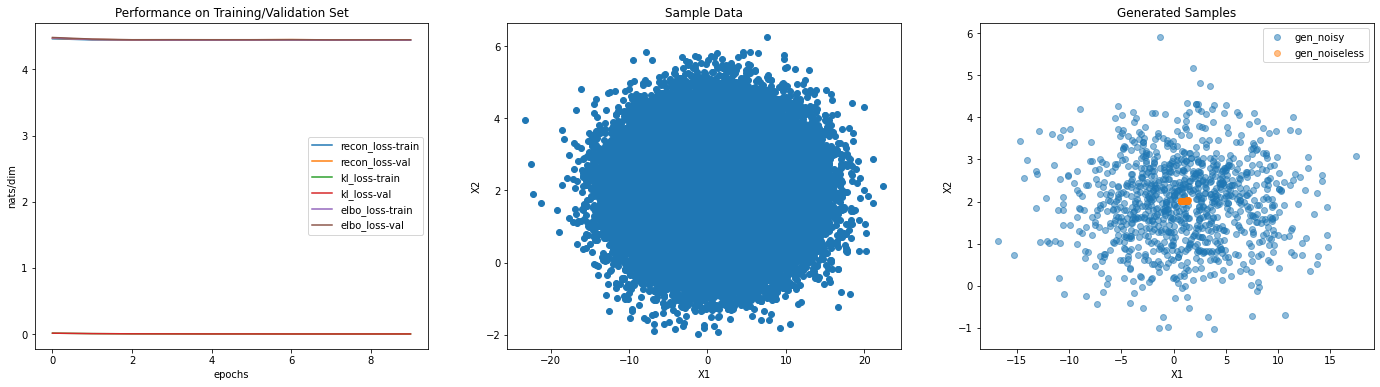

In [10]:
# plot results for data 1
plot(training_history, validation_history, data1, model)

In [12]:
# Dataset 2

lr = 0.01
epochs = 10
batch_size = 256

input_dim = 2
latent_dim = 2

hiddens_enc = [{'dim':2,'act':'relu','bn':False}]
hiddens_dec = [{'dim':2,'act':'relu','bn':False}]

model, training_history, validation_history = solution(data2,batch_size,input_dim,latent_dim,hiddens_enc,hiddens_dec,lr,epochs)

Setup Dataloaders

Setup Engines

Run Engines

Training Results - Epoch 1 - ELBO loss: 5.94 RECON loss: 5.73 KL loss: 0.20
Validation Results - Epoch 1 - ELBO loss: 5.93 RECON loss: 5.72 KL loss: 0.20
Training Results - Epoch 2 - ELBO loss: 5.39 RECON loss: 5.26 KL loss: 0.13
Validation Results - Epoch 2 - ELBO loss: 5.39 RECON loss: 5.26 KL loss: 0.13
Training Results - Epoch 3 - ELBO loss: 5.27 RECON loss: 4.97 KL loss: 0.30
Validation Results - Epoch 3 - ELBO loss: 5.28 RECON loss: 4.97 KL loss: 0.31
Training Results - Epoch 4 - ELBO loss: 5.11 RECON loss: 4.49 KL loss: 0.62
Validation Results - Epoch 4 - ELBO loss: 5.10 RECON loss: 4.48 KL loss: 0.63
Training Results - Epoch 5 - ELBO loss: 4.67 RECON loss: 3.43 KL loss: 1.25
Validation Results - Epoch 5 - ELBO loss: 4.68 RECON loss: 3.43 KL loss: 1.25
Training Results - Epoch 6 - ELBO loss: 4.48 RECON loss: 2.86 KL loss: 1.62
Validation Results - Epoch 6 - ELBO loss: 4.48 RECON loss: 2.86 KL loss: 1.62
Training Results - Epoch 7 - 

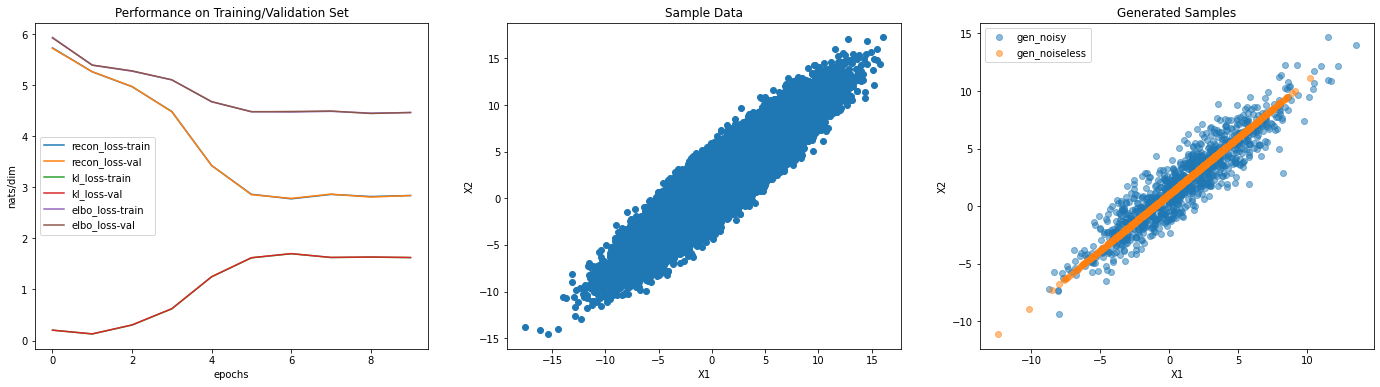

In [13]:
# plot results for data 1
plot(training_history, validation_history, data2, model)

In [27]:
# Dataset 3

lr = 0.001
epochs = 30
batch_size = 256

input_dim = 2
latent_dim = 2

hiddens_enc = [{'dim':2,'act':'relu','bn':False},{'dim':2,'act':'relu','bn':False}]
hiddens_dec = [{'dim':2,'act':'relu','bn':False},{'dim':2,'act':'relu','bn':False}]

model, training_history, validation_history = solution(data3[0],batch_size,input_dim,latent_dim,hiddens_enc,hiddens_dec,lr,epochs)

Setup Dataloaders

Setup Engines

Run Engines

Training Results - Epoch 1 - ELBO loss: 3.65 RECON loss: 3.64 KL loss: 0.01
Validation Results - Epoch 1 - ELBO loss: 3.65 RECON loss: 3.64 KL loss: 0.01
Training Results - Epoch 2 - ELBO loss: 3.64 RECON loss: 3.64 KL loss: 0.01
Validation Results - Epoch 2 - ELBO loss: 3.64 RECON loss: 3.64 KL loss: 0.01
Training Results - Epoch 3 - ELBO loss: 3.64 RECON loss: 3.64 KL loss: 0.01
Validation Results - Epoch 3 - ELBO loss: 3.64 RECON loss: 3.63 KL loss: 0.01
Training Results - Epoch 4 - ELBO loss: 3.64 RECON loss: 3.63 KL loss: 0.01
Validation Results - Epoch 4 - ELBO loss: 3.64 RECON loss: 3.63 KL loss: 0.01
Training Results - Epoch 5 - ELBO loss: 3.64 RECON loss: 3.63 KL loss: 0.01
Validation Results - Epoch 5 - ELBO loss: 3.64 RECON loss: 3.63 KL loss: 0.01
Training Results - Epoch 6 - ELBO loss: 3.64 RECON loss: 3.63 KL loss: 0.01
Validation Results - Epoch 6 - ELBO loss: 3.64 RECON loss: 3.62 KL loss: 0.01
Training Results - Epoch 7 - 

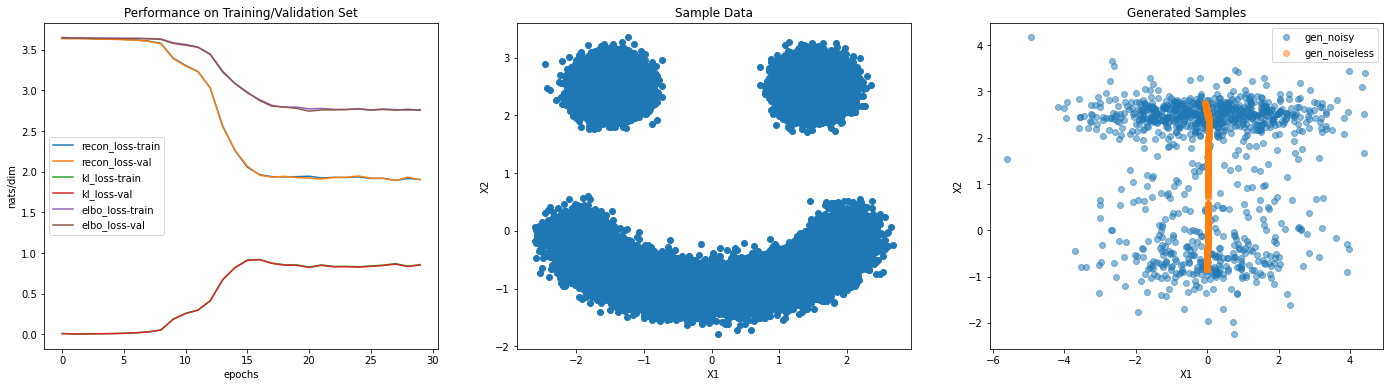

In [28]:
# plot results for data 1
plot(training_history, validation_history, data3[0], model)